# Setup and Imports

In [4]:
# Setup
import sys
sys.path.append('../src')

from data_loader import load_sector_data, get_seasonal_returns, calculate_sector_ratio
from returns_calculator import (
    calculate_annual_returns_from_monthly,
    calculate_seasonal_returns
)
from sharpe_analysis import (
    calculate_sharpe_ratio,
    calculate_sharpe_ratio_by_season
)
from stats_analysis import calculate_statistics, seasonal_ttest
from visualization import plot_seasonal_comparison, plot_monthly_averages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✓ Setup complete!")

✓ Setup complete!


# Load data

In [5]:
# Load the data
file_path = '../data/Seasonal S&P Data as of 11.13.2025 - Abhi.xlsx'

df_disc = load_sector_data(file_path, 'Discretionary')
df_disc = df_disc[df_disc.index > 1994]
df_staples = load_sector_data(file_path, 'Staples')
df_staples = df_staples[df_staples.index > 1994]

print("Discretionary data:")
print(f"  Years: {df_disc.index.min()} - {df_disc.index.max()}")
print(f"  Shape: {df_disc.shape}")

print("\nStaples data:")
print(f"  Years: {df_staples.index.min()} - {df_staples.index.max()}")
print(f"  Shape: {df_staples.shape}")

print("\nFirst few rows of Discretionary:")
print(df_disc.head())

Discretionary data:
  Years: 1995 - 2025
  Shape: (31, 12)

Staples data:
  Years: 1995 - 2025
  Shape: (31, 12)

First few rows of Discretionary:
       Jan   Feb    Mar    Apr    May    Jun    Jul     Aug    Sep    Oct  \
Year                                                                        
1995 0.647 3.394  3.016 -1.341  4.460  2.637  3.299  -2.237  1.248 -4.807   
1996 2.026 2.017  4.059  2.350  2.925 -1.890 -6.969   3.345  2.195  0.768   
1997 2.337 2.971 -1.896  3.884  4.494  3.307  7.730  -3.585  5.090 -2.191   
1998 1.268 9.760  6.244  2.295  3.271  4.078 -0.641 -15.428 -0.886 11.466   
1999 5.618 0.145  4.409  2.569 -4.353  5.939 -5.865  -3.518  0.471  7.044   

       Nov    Dec  
Year               
1995 6.215  0.816  
1996 4.598 -4.225  
1997 4.333  2.466  
1998 7.532  7.669  
1999 0.957  9.604  


# Align common time period

In [6]:
# Find common years (Staples starts later than Discretionary)
common_years = df_disc.index.intersection(df_staples.index)
print(common_years)

print(f"Common time period: {common_years.min()} - {common_years.max()}")
print(f"Number of years: {len(common_years)}")

# Filter both to common period
df_disc_aligned = df_disc.loc[common_years]
df_staples_aligned = df_staples.loc[common_years]

print("\n✓ Data aligned to common period")

Index([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025],
      dtype='int64', name='Year')
Common time period: 1995 - 2025
Number of years: 31

✓ Data aligned to common period


# Basic stats discretionary

In [7]:
# Calculate statistics for Discretionary
disc_all_returns = df_disc_aligned.values.flatten()
disc_all_returns = disc_all_returns[~np.isnan(disc_all_returns)]

print("="*70)
print("CONSUMER DISCRETIONARY - BASIC STATISTICS")
print("="*70)

disc_stats = calculate_statistics(disc_all_returns)
for key, value in disc_stats.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.3f}")
    else:
        print(f"{key:20s}: {value}")

CONSUMER DISCRETIONARY - BASIC STATISTICS
count               : 370
mean                :    0.959
median              :    1.020
std                 :    5.466
min                 :  -19.268
max                 :   20.514
skewness            :   -0.096
kurtosis            :    1.219
positive_pct        :   60.811


# Basic stats staples

In [8]:
# Calculate statistics for Staples
staples_all_returns = df_staples_aligned.values.flatten()
staples_all_returns = staples_all_returns[~np.isnan(staples_all_returns)]

print("="*70)
print("CONSUMER STAPLES - BASIC STATISTICS")
print("="*70)

staples_stats = calculate_statistics(staples_all_returns)
for key, value in staples_stats.items():
    if isinstance(value, float):
        print(f"{key:20s}: {value:8.3f}")
    else:
        print(f"{key:20s}: {value}")

CONSUMER STAPLES - BASIC STATISTICS
count               : 370
mean                :    0.655
median              :    1.047
std                 :    3.661
min                 :  -11.883
max                 :   14.922
skewness            :   -0.298
kurtosis            :    1.107
positive_pct        :   60.541


# Performance comparison

In [9]:
# Side-by-side comparison
print("="*70)
print("DISCRETIONARY vs STAPLES - OVERALL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Discretionary': [
        disc_stats['mean'],
        disc_stats['std'],
        disc_stats['skewness'],
        disc_stats['kurtosis'],
        disc_stats['positive_pct']
    ],
    'Staples': [
        staples_stats['mean'],
        staples_stats['std'],
        staples_stats['skewness'],
        staples_stats['kurtosis'],
        staples_stats['positive_pct']
    ]
}, index=['Mean Return (%)', 'Std Dev (%)', 
          'Skewness', 'Kurtosis', '% Positive'])

comparison_df['Difference'] = comparison_df['Discretionary'] - comparison_df['Staples']

print(comparison_df)

DISCRETIONARY vs STAPLES - OVERALL COMPARISON
                 Discretionary  Staples  Difference
Mean Return (%)          0.959    0.655       0.304
Std Dev (%)              5.466    3.661       1.805
Skewness                -0.096   -0.298       0.202
Kurtosis                 1.219    1.107       0.112
% Positive              60.811   60.541       0.270


# Seasonal Analysis - Discretionary

In [10]:
# Get seasonal returns for Discretionary
disc_winter = get_seasonal_returns(df_disc_aligned, 'winter')
disc_summer = get_seasonal_returns(df_disc_aligned, 'summer')

print("="*70)
print("CONSUMER DISCRETIONARY - SEASONAL ANALYSIS")
print("="*70)

print("\nWINTER (Nov-Apr):")
print(f"  Mean:           {np.mean(disc_winter):.3f}%")
print(f"  Std Dev:        {np.std(disc_winter):.3f}%")
#print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(disc_winter):.3f}")
print(f"  % Positive:     {(disc_winter > 0).sum() / len(disc_winter) * 100:.1f}%")

print("\nSUMMER (May-Oct):")
print(f"  Mean:           {np.mean(disc_summer):.3f}%")
print(f"  Std Dev:        {np.std(disc_summer):.3f}%")
#print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(disc_summer):.3f}")
print(f"  % Positive:     {(disc_summer > 0).sum() / len(disc_summer) * 100:.1f}%")

print("\nDIFFERENCE (Winter - Summer):")
print(f"  Mean diff:      {np.mean(disc_winter) - np.mean(disc_summer):.3f}%")

# T-test
disc_ttest = seasonal_ttest(disc_winter, disc_summer)
print(f"\nT-test: p-value = {disc_ttest['p_value']:.6f}")
if disc_ttest['significant_05']:
    print("✓ Seasonality is statistically significant (p < 0.05)")
else:
    print("✗ Seasonality is NOT statistically significant (p >= 0.05)")

CONSUMER DISCRETIONARY - SEASONAL ANALYSIS

WINTER (Nov-Apr):
  Mean:           1.517%
  Std Dev:        5.499%
  % Positive:     65.2%

SUMMER (May-Oct):
  Mean:           0.407%
  Std Dev:        5.363%
  % Positive:     56.5%

DIFFERENCE (Winter - Summer):
  Mean diff:      1.110%

T-test: p-value = 0.050745
✗ Seasonality is NOT statistically significant (p >= 0.05)


# Seasonal Analysis - Staples

In [11]:
# Get seasonal returns for Staples
staples_winter = get_seasonal_returns(df_staples_aligned, 'winter')
staples_summer = get_seasonal_returns(df_staples_aligned, 'summer')

print("="*70)
print("CONSUMER STAPLES - SEASONAL ANALYSIS")
print("="*70)

print("\nWINTER (Nov-Apr):")
print(f"  Mean:           {np.mean(staples_winter):.3f}%")
print(f"  Std Dev:        {np.std(staples_winter):.3f}%")
# print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(staples_winter):.3f}")
print(f"  % Positive:     {(staples_winter > 0).sum() / len(staples_winter) * 100:.1f}%")

print("\nSUMMER (May-Oct):")
print(f"  Mean:           {np.mean(staples_summer):.3f}%")
print(f"  Std Dev:        {np.std(staples_summer):.3f}%")
# print(f"  Sharpe Ratio:   {calculate_sharpe_ratio(staples_summer):.3f}")
print(f"  % Positive:     {(staples_summer > 0).sum() / len(staples_summer) * 100:.1f}%")

print("\nDIFFERENCE (Winter - Summer):")
print(f"  Mean diff:      {np.mean(staples_winter) - np.mean(staples_summer):.3f}%")

# T-test
staples_ttest = seasonal_ttest(staples_winter, staples_summer)
print(f"\nT-test: p-value = {staples_ttest['p_value']:.6f}")
if staples_ttest['significant_05']:
    print("✓ Seasonality is statistically significant (p < 0.05)")
else:
    print("✗ Seasonality is NOT statistically significant (p >= 0.05)")

CONSUMER STAPLES - SEASONAL ANALYSIS

WINTER (Nov-Apr):
  Mean:           0.806%
  Std Dev:        3.466%
  % Positive:     64.1%

SUMMER (May-Oct):
  Mean:           0.507%
  Std Dev:        3.829%
  % Positive:     57.0%

DIFFERENCE (Winter - Summer):
  Mean diff:      0.299%

T-test: p-value = 0.432602
✗ Seasonality is NOT statistically significant (p >= 0.05)


# Visuals - Discretionary Seasonal

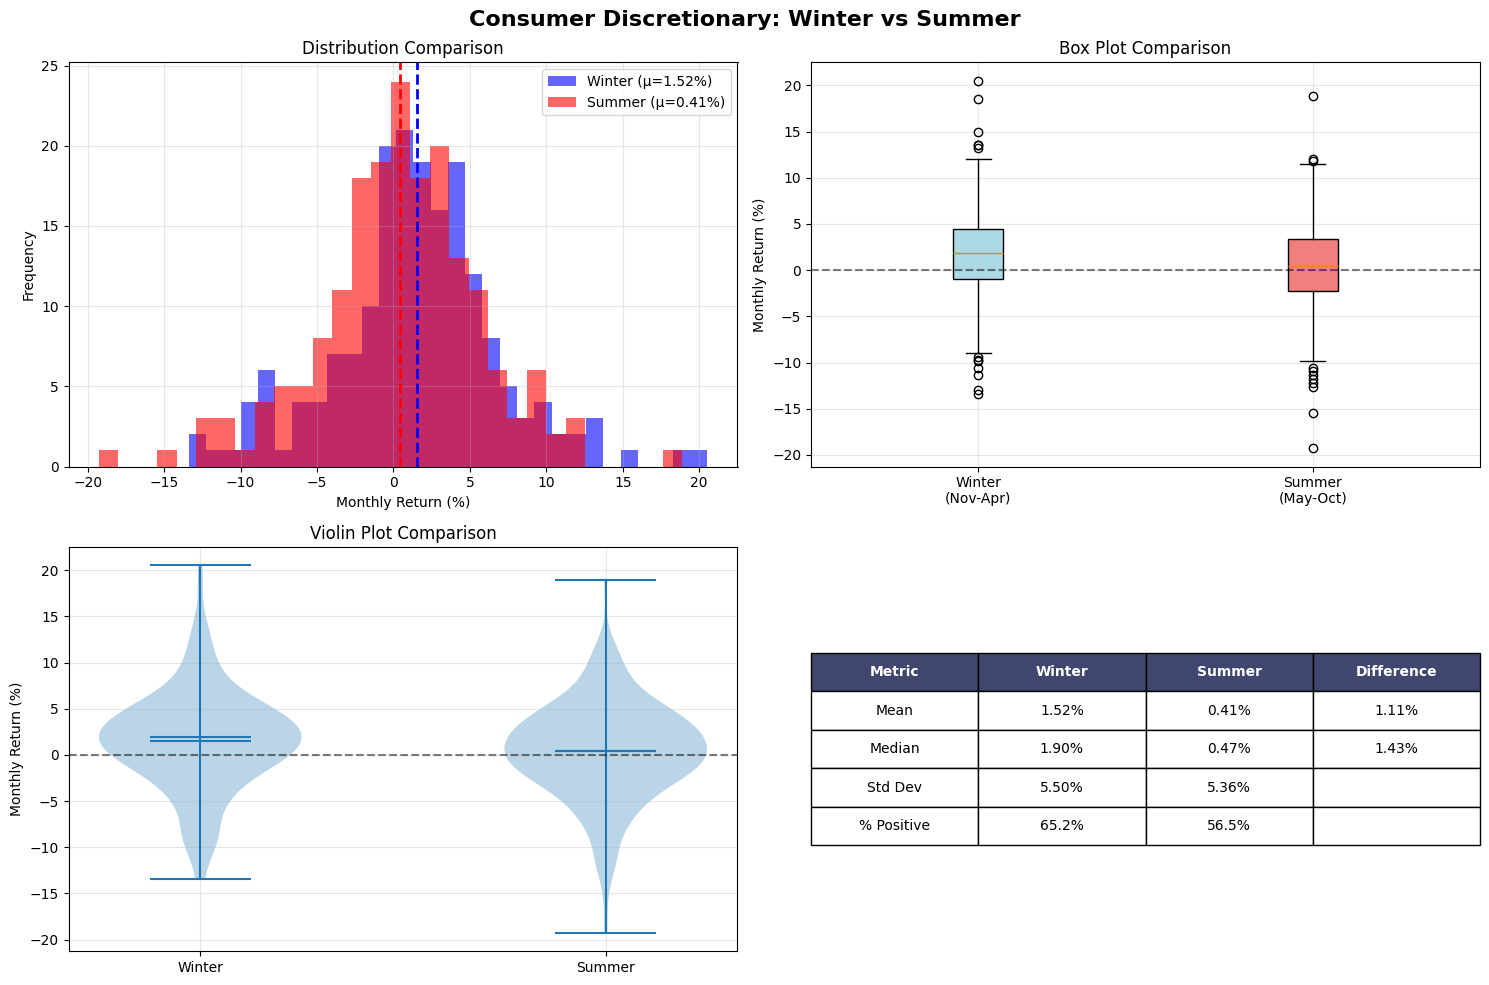

In [12]:
# Visualize Discretionary seasonal pattern
plot_seasonal_comparison(disc_winter, disc_summer, 
                        "Consumer Discretionary: Winter vs Summer")

# Visuals - Staples Seasonal

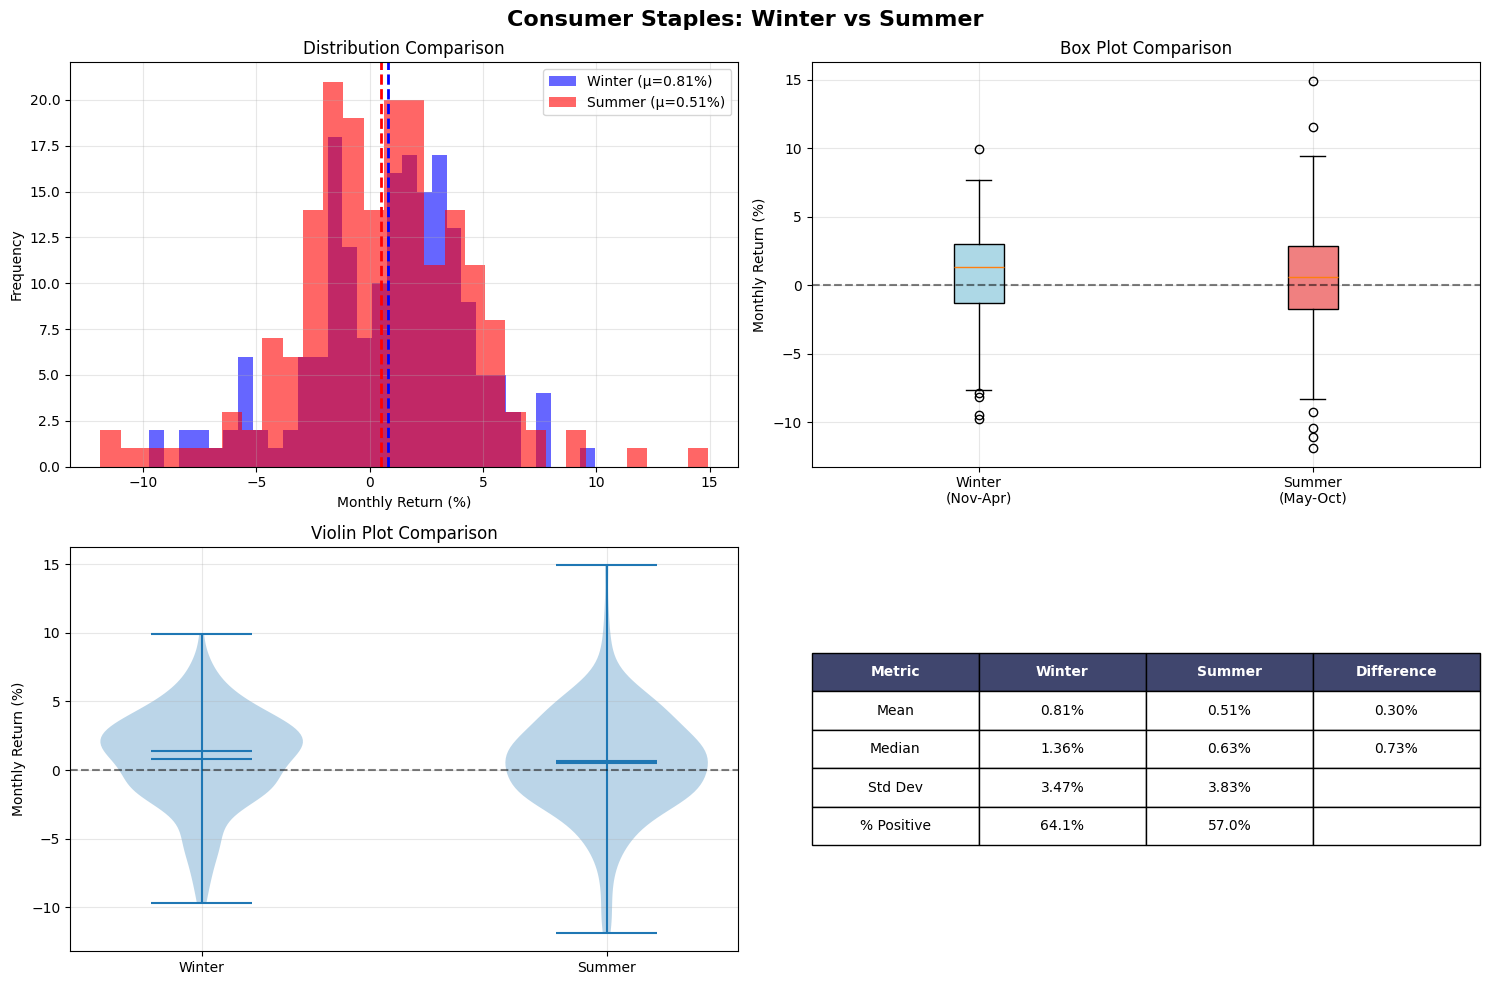

In [13]:
# Visualize Staples seasonal pattern
plot_seasonal_comparison(staples_winter, staples_summer, 
                        "Consumer Staples: Winter vs Summer")

# Discretionary / Staples Ratio

In [14]:
# Calculate the ratio (outperformance)
# Discretionary return - Staples return = offensive outperformance
df_ratio = calculate_sector_ratio(df_disc_aligned, df_staples_aligned)

print("Discretionary/Staples Ratio (Outperformance):")
print(f"Shape: {df_ratio.shape}")
print(f"\nFirst few years:")
print(df_ratio.head())

# Calculate average ratio by month
ratio_monthly_avg = df_ratio.mean()
print(f"\nAverage monthly outperformance:")
print(ratio_monthly_avg)

Discretionary/Staples Ratio (Outperformance):
Shape: (31, 12)

First few years:
        Jan    Feb   Mar    Apr    May    Jun    Jul    Aug    Sep    Oct  \
Year                                                                        
1995 -1.403  0.533 0.130 -4.175  0.156  1.022  3.307 -1.752 -6.043 -7.345   
1996 -0.881 -0.080 5.463  2.536 -2.904 -5.706 -4.306  4.533 -3.403 -0.722   
1997 -3.473 -1.462 3.843 -3.806 -0.421 -0.031  4.010  5.647  0.535 -0.140   
1998  3.405  3.662 1.605  5.333  1.741  0.249  3.968 -3.545 -1.092 -3.456   
1999  7.908  4.400 6.625  1.460 -4.543  7.176 -4.901 -1.682 10.903 -0.101   

        Nov    Dec  
Year                
1995  1.916 -0.538  
1996 -0.757 -4.572  
1997 -3.042 -1.207  
1998  3.352  5.985  
1999 -0.320 13.142  

Average monthly outperformance:
Jan    1.484
Feb   -0.313
Mar    0.712
Apr    1.061
May   -0.484
Jun    0.442
Jul    0.615
Aug   -0.341
Sep   -0.154
Oct   -0.673
Nov    1.055
Dec    0.266
dtype: float64


# Analyse ratio overtime

In [15]:
# Flatten ratio to analyze
ratio_all = df_ratio.values.flatten()
ratio_all = ratio_all[~np.isnan(ratio_all)]

print("="*70)
print("DISCRETIONARY/STAPLES RATIO ANALYSIS")
print("="*70)

print(f"\nMean ratio:     {np.mean(ratio_all):.3f}%")
print(f"Median ratio:   {np.median(ratio_all):.3f}%")
print(f"Std dev:        {np.std(ratio_all):.3f}%")
print(f"% Disc wins:    {(ratio_all > 0).sum() / len(ratio_all) * 100:.1f}%")

# Test if ratio is significantly different from zero
t_stat, p_val = stats.ttest_1samp(ratio_all, 0)
print(f"\nOne-sample t-test (H0: ratio = 0):")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value:     {p_val:.6f}")

if p_val < 0.05:
    if np.mean(ratio_all) > 0:
        print("✓ Discretionary significantly outperforms Staples overall")
    else:
        print("✓ Staples significantly outperforms Discretionary overall")
else:
    print("✗ No significant difference between Disc and Staples overall")

DISCRETIONARY/STAPLES RATIO ANALYSIS

Mean ratio:     0.304%
Median ratio:   0.253%
Std dev:        4.789%
% Disc wins:    54.1%

One-sample t-test (H0: ratio = 0):
  t-statistic: 1.219
  p-value:     0.223575
✗ No significant difference between Disc and Staples overall


# Ratio Seasonal Analysis

In [16]:
# Analyze ratio by season
ratio_winter = get_seasonal_returns(df_ratio, 'winter')
ratio_summer = get_seasonal_returns(df_ratio, 'summer')

print("="*70)
print("RATIO SEASONAL ANALYSIS")
print("="*70)

print("\nWINTER (Nov-Apr) - Disc Outperformance:")
print(f"  Mean:        {np.mean(ratio_winter):.3f}%")
print(f"  % Disc wins: {(ratio_winter > 0).sum() / len(ratio_winter) * 100:.1f}%")

print("\nSUMMER (May-Oct) - Disc Outperformance:")
print(f"  Mean:        {np.mean(ratio_summer):.3f}%")
print(f"  % Disc wins: {(ratio_summer > 0).sum() / len(ratio_summer) * 100:.1f}%")

print("\nDIFFERENCE:")
print(f"  Disc outperforms more in: {'Winter' if np.mean(ratio_winter) > np.mean(ratio_summer) else 'Summer'}")
print(f"  Difference: {np.mean(ratio_winter) - np.mean(ratio_summer):.3f}%")

# T-test
ratio_seasonal_test = seasonal_ttest(ratio_winter, ratio_summer)
print(f"\nT-test p-value: {ratio_seasonal_test['p_value']:.6f}")

RATIO SEASONAL ANALYSIS

WINTER (Nov-Apr) - Disc Outperformance:
  Mean:        0.711%
  % Disc wins: 58.2%

SUMMER (May-Oct) - Disc Outperformance:
  Mean:        -0.099%
  % Disc wins: 50.0%

DIFFERENCE:
  Disc outperforms more in: Winter
  Difference: 0.811%

T-test p-value: 0.104124


# Visualize ratio distributions

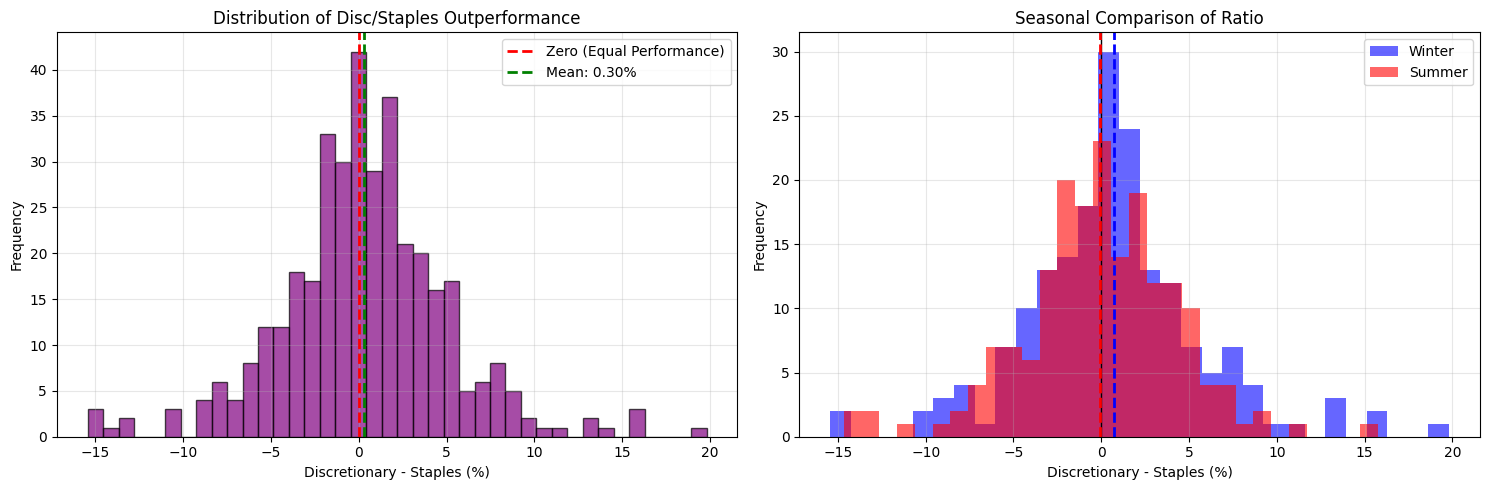

In [17]:
# Visualize the ratio distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(ratio_all, bins=40, edgecolor='black', alpha=0.7, color='purple')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero (Equal Performance)')
axes[0].axvline(np.mean(ratio_all), color='green', linestyle='--', 
                linewidth=2, label=f'Mean: {np.mean(ratio_all):.2f}%')
axes[0].set_xlabel('Discretionary - Staples (%)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Disc/Staples Outperformance')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Seasonal comparison
axes[1].hist(ratio_winter, bins=30, alpha=0.6, label='Winter', color='blue')
axes[1].hist(ratio_summer, bins=30, alpha=0.6, label='Summer', color='red')
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].axvline(np.mean(ratio_winter), color='blue', linestyle='--', linewidth=2)
axes[1].axvline(np.mean(ratio_summer), color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Discretionary - Staples (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Seasonal Comparison of Ratio')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Time series of ratio: 

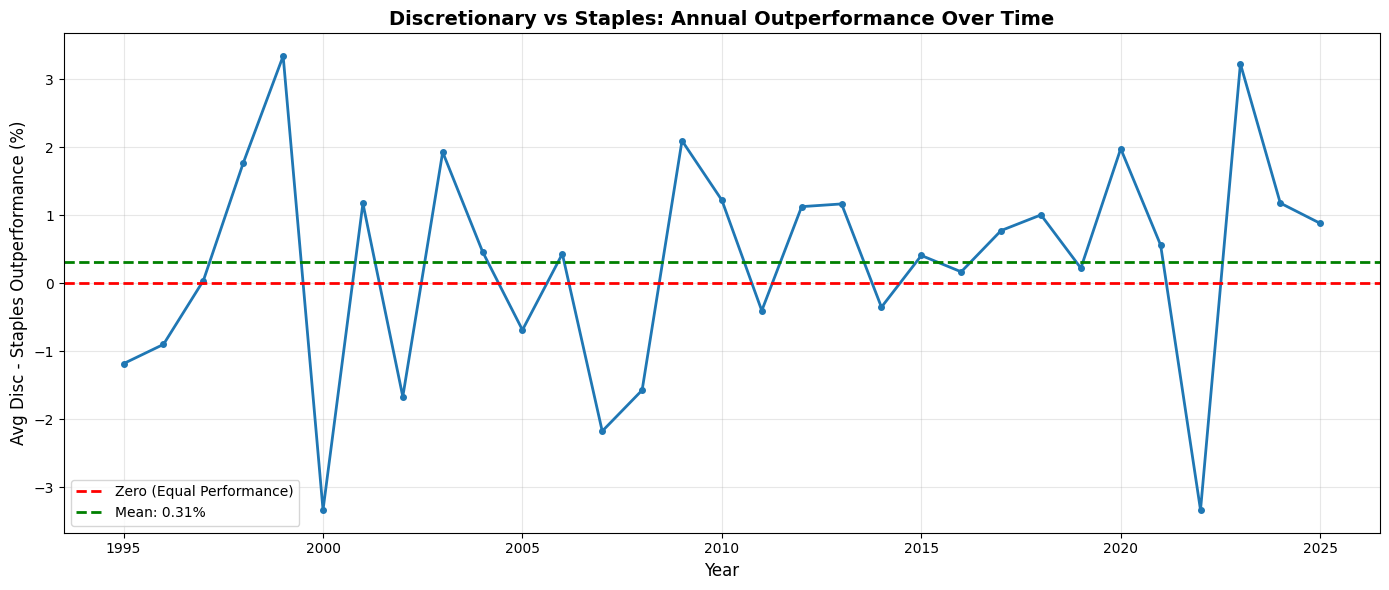

Trend analysis:
  1990s avg: 0.612%
  2000s avg: -0.335%
  2010s avg: 0.532%
  2020s avg: 0.747%


In [19]:
# Plot ratio over time (annual average)
annual_ratio = df_ratio.mean(axis=1)  # Average across all months per year

plt.figure(figsize=(14, 6))
plt.plot(annual_ratio.index, annual_ratio.values, marker='o', linewidth=2, markersize=4)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label='Zero (Equal Performance)')
plt.axhline(np.mean(annual_ratio), color='green', linestyle='--', 
            linewidth=2, label=f'Mean: {np.mean(annual_ratio):.2f}%')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Avg Disc - Staples Outperformance (%)', fontsize=12)
plt.title('Discretionary vs Staples: Annual Outperformance Over Time', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Trend analysis:")
print(f"  1990s avg: {annual_ratio[annual_ratio.index < 2000].mean():.3f}%")
print(f"  2000s avg: {annual_ratio[(annual_ratio.index >= 2000) & (annual_ratio.index < 2010)].mean():.3f}%")
print(f"  2010s avg: {annual_ratio[(annual_ratio.index >= 2010) & (annual_ratio.index < 2020)].mean():.3f}%")
print(f"  2020s avg: {annual_ratio[annual_ratio.index >= 2020].mean():.3f}%")

# Heatmap of ratios

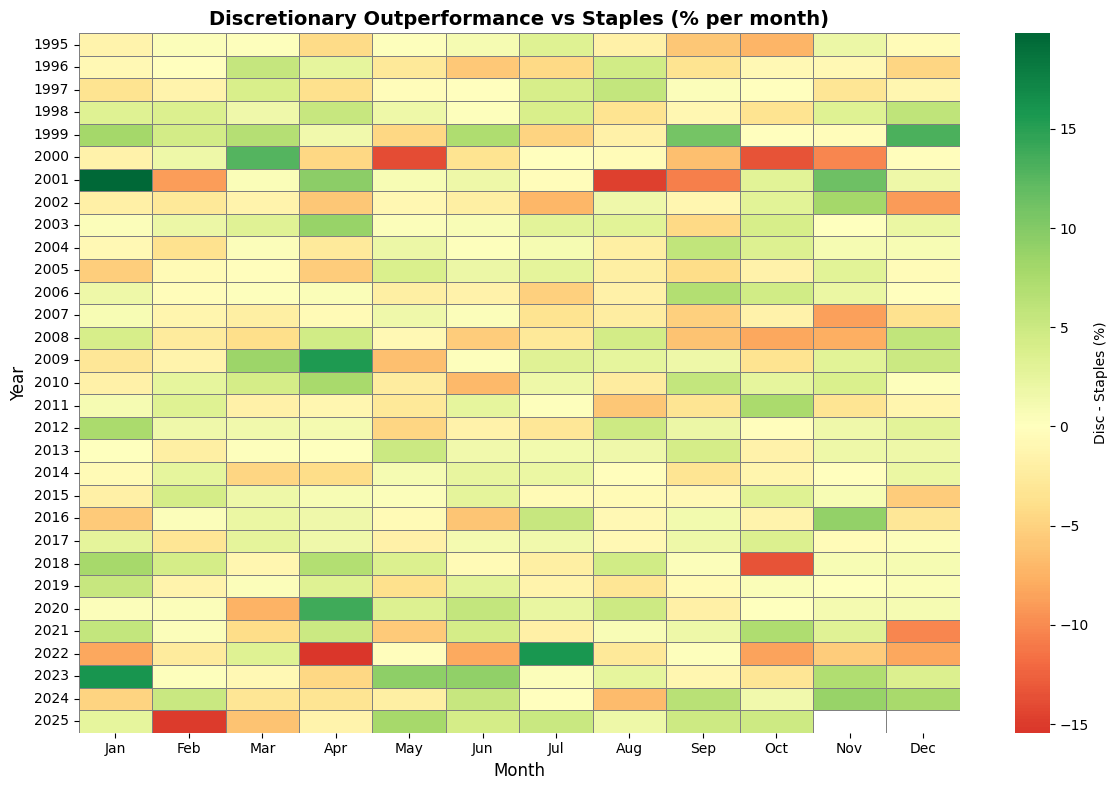

In [20]:
# Create heatmap showing which months Disc outperforms
plt.figure(figsize=(12, 8))
sns.heatmap(df_ratio, cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Disc - Staples (%)'},
            linewidths=0.5, linecolor='gray')
plt.title('Discretionary Outperformance vs Staples (% per month)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)
plt.tight_layout()
plt.show()

# Sharpe ratio analysis

In [21]:
df_tbills = load_sector_data(file_path, 'TBills')
# Load tbill data
print("Loading data...")
print(df_tbills.head())

Loading data...
       Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                        
2001   NaN   NaN   NaN   NaN   NaN   NaN   NaN 3.480 2.630 2.240 1.960 1.690
2002 1.650 1.700 1.750 1.690 1.710 1.680 1.690 1.660 1.650 1.600 1.240 1.180
2003 1.150 1.180 1.160 1.140 1.060 0.960 0.880 0.930 0.890 0.890 0.920 0.870
2004 0.830 0.900 0.950 0.890 0.890 1.020 1.160 1.350 1.520 1.600 1.880 1.920
2005 1.990 2.320 2.600 2.590 2.590 2.780 3.040 3.280 3.160 3.440 3.840 3.610


## align data to common years

In [22]:
# Find common years across all three datasets
common_years = (df_disc.index
                .intersection(df_staples.index)
                .intersection(df_tbills.index))

# Align all data
df_disc_aligned = df_disc.loc[common_years]
df_staples_aligned = df_staples.loc[common_years]
df_rf_aligned = df_tbills.loc[common_years]

print("="*70)
print("ALIGNED DATA")
print("="*70)
print(f"Common period: {common_years.min()} to {common_years.max()}")
print(f"Number of years: {len(common_years)}")
print(f"Total months: {len(common_years) * 12}")

print("\nSample (year 2020):")
print("\nDiscretionary:")
print(df_disc_aligned.loc[2020])
print("\nStaples:")
print(df_staples_aligned.loc[2020])
print("\nRisk-Free Rate (monthly):")
print(df_rf_aligned.loc[2020])

ALIGNED DATA
Common period: 2001 to 2025
Number of years: 25
Total months: 300

Sample (year 2020):

Discretionary:
Jan     0.580
Feb    -7.686
Mar   -13.394
Apr    20.514
May     4.863
Jun     4.902
Jul     8.978
Aug     9.435
Sep    -3.686
Oct    -2.953
Nov     8.481
Dec     2.449
Name: 2020, dtype: float64

Staples:
Jan    0.198
Feb   -8.182
Mar   -5.860
Apr    6.644
May    1.376
Jun   -0.735
Jul    6.765
Aug    4.598
Sep   -1.845
Oct   -2.986
Nov    7.336
Dec    1.450
Name: 2020, dtype: float64

Risk-Free Rate (monthly):
Jan   1.500
Feb   1.550
Mar   0.360
Apr   0.110
May   0.100
Jun   0.130
Jul   0.110
Aug   0.080
Sep   0.090
Oct   0.090
Nov   0.090
Dec   0.080
Name: 2020, dtype: float64


## Calculating excess returns

In [23]:
# Calculate annual returns (excess of risk-free)
print("Calculating annual returns...")

annual_disc = calculate_annual_returns_from_monthly(df_disc_aligned, df_rf_aligned)
annual_stap = calculate_annual_returns_from_monthly(df_staples_aligned, df_rf_aligned)

# Clean any NaN years
annual_disc_clean = annual_disc.dropna()
annual_stap_clean = annual_stap.dropna()

print("="*70)
print("ANNUAL EXCESS RETURNS")
print("="*70)

print(f"\nConsumer Discretionary:")
print(f"  Sample size:     {len(annual_disc_clean)} years")
print(f"  Mean:            {annual_disc_clean.mean():.2f}%")
print(f"  Median:          {annual_disc_clean.median():.2f}%")
print(f"  Std deviation:   {annual_disc_clean.std(ddof=1):.2f}%")
print(f"  Min:             {annual_disc_clean.min():.2f}%")
print(f"  Max:             {annual_disc_clean.max():.2f}%")

print(f"\nConsumer Staples:")
print(f"  Sample size:     {len(annual_stap_clean)} years")
print(f"  Mean:            {annual_stap_clean.mean():.2f}%")
print(f"  Median:          {annual_stap_clean.median():.2f}%")
print(f"  Std deviation:   {annual_stap_clean.std(ddof=1):.2f}%")
print(f"  Min:             {annual_stap_clean.min():.2f}%")
print(f"  Max:             {annual_stap_clean.max():.2f}%")

print(f"\n" + "="*70)
print("COMPARISON:")
print(f"  Mean difference:     {annual_disc_clean.mean() - annual_stap_clean.mean():.2f}%")
print(f"  Volatility ratio:    {annual_disc_clean.std(ddof=1) / annual_stap_clean.std(ddof=1):.2f}x")

Calculating annual returns...
ANNUAL EXCESS RETURNS

Consumer Discretionary:
  Sample size:     25 years
  Mean:            9.69%
  Median:          10.90%
  Std deviation:   22.24%
  Min:             -39.18%
  Max:             40.91%

Consumer Staples:
  Sample size:     25 years
  Mean:            4.12%
  Median:          7.17%
  Std deviation:   10.27%
  Min:             -17.51%
  Max:             22.64%

COMPARISON:
  Mean difference:     5.57%
  Volatility ratio:    2.17x


## Calculate Sharpe Ratios: 

In [24]:
# Calculate Sharpe ratios on ANNUAL data
sharpe_disc = calculate_sharpe_ratio(annual_disc_clean, frequency='annual')
sharpe_stap = calculate_sharpe_ratio(annual_stap_clean, frequency='annual')

print("="*70)
print("SHARPE RATIOS (Annualized, using Annual Data)")
print("="*70)

print(f"\nConsumer Discretionary:")
print(f"  Annualized Excess Return:   {annual_disc_clean.mean():.2f}%")
print(f"  Annualized Vol:      {annual_disc_clean.std(ddof=1):.2f}%")
print(f"  Sharpe Ratio:        {sharpe_disc:.3f}")

print(f"\nConsumer Staples:")
print(f"  Annualized Excess Return:   {annual_stap_clean.mean():.2f}%")
print(f"  Annualized Vol:      {annual_stap_clean.std(ddof=1):.2f}%")
print(f"  Sharpe Ratio:        {sharpe_stap:.3f}")

print(f"\n" + "="*70)
print("WINNER:")
print("="*70)
if sharpe_disc > sharpe_stap:
    print(f"✓ Discretionary has superior risk-adjusted returns")
    print(f"  Sharpe advantage: {sharpe_disc - sharpe_stap:.3f}")
    print(f"  ({(sharpe_disc - sharpe_stap) / sharpe_stap * 100:.1f}% higher)")
else:
    print(f"✓ Staples has superior risk-adjusted returns")
    print(f"  Sharpe advantage: {sharpe_stap - sharpe_disc:.3f}")
    print(f"  ({(sharpe_stap - sharpe_disc) / sharpe_disc * 100:.1f}% higher)")

print("\nBenchmark interpretation:")
print("  SR > 0.5  = Decent")
print("  SR > 1.0  = Good")
print("  SR > 2.0  = Excellent")

SHARPE RATIOS (Annualized, using Annual Data)

Consumer Discretionary:
  Annualized Excess Return:   9.69%
  Annualized Vol:      22.24%
  Sharpe Ratio:        0.436

Consumer Staples:
  Annualized Excess Return:   4.12%
  Annualized Vol:      10.27%
  Sharpe Ratio:        0.401

WINNER:
✓ Discretionary has superior risk-adjusted returns
  Sharpe advantage: 0.035
  (8.7% higher)

Benchmark interpretation:
  SR > 0.5  = Decent
  SR > 1.0  = Good
  SR > 2.0  = Excellent


# Seasonal Sharpe Ratios

In [25]:
# Calculate Sharpe ratios by season
print("="*70)
print("SEASONAL SHARPE RATIOS")
print("="*70)

# Winter season (Nov-Apr)
sharpe_disc_winter = calculate_sharpe_ratio_by_season(df_disc_aligned, df_rf_aligned, season='winter')
sharpe_stap_winter = calculate_sharpe_ratio_by_season(df_staples_aligned, df_rf_aligned, season='winter')

# Summer season (May-Oct)
sharpe_disc_summer = calculate_sharpe_ratio_by_season(df_disc_aligned, df_rf_aligned, season='summer')
sharpe_stap_summer = calculate_sharpe_ratio_by_season(df_staples_aligned, df_rf_aligned, season='summer')

print("\nWINTER SEASON (Nov-Apr):")
print(f"  Discretionary:  {sharpe_disc_winter:.3f}")
print(f"  Staples:        {sharpe_stap_winter:.3f}")
print(f"  Advantage:      {sharpe_disc_winter - sharpe_stap_winter:+.3f} (Disc)")

print("\nSUMMER SEASON (May-Oct):")
print(f"  Discretionary:  {sharpe_disc_summer:.3f}")
print(f"  Staples:        {sharpe_stap_summer:.3f}")
print(f"  Advantage:      {sharpe_stap_summer - sharpe_disc_summer:+.3f} (Stap)")

print("\n" + "="*70)
print("SEASONAL PATTERN:")
print("="*70)

disc_seasonal_diff = sharpe_disc_winter - sharpe_disc_summer
stap_seasonal_diff = sharpe_stap_winter - sharpe_stap_summer

print(f"\nDiscretionary: Winter {'+' if disc_seasonal_diff > 0 else ''}{disc_seasonal_diff:.3f} vs Summer")
print(f"Staples:       Winter {'+' if stap_seasonal_diff > 0 else ''}{stap_seasonal_diff:.3f} vs Summer")

if disc_seasonal_diff > stap_seasonal_diff:
    print("\n✓ Discretionary shows STRONGER seasonal effect")
    print("  (More offensive in good season)")
else:
    print("\n✓ Staples shows MORE DEFENSIVE properties")
    print("  (Better risk-adjusted returns in weak season) hell0")

SEASONAL SHARPE RATIOS

WINTER SEASON (Nov-Apr):
  Discretionary:  0.746
  Staples:        0.790
  Advantage:      -0.044 (Disc)

SUMMER SEASON (May-Oct):
  Discretionary:  0.245
  Staples:        0.223
  Advantage:      -0.022 (Stap)

SEASONAL PATTERN:

Discretionary: Winter +0.501 vs Summer
Staples:       Winter +0.567 vs Summer

✓ Staples shows MORE DEFENSIVE properties
  (Better risk-adjusted returns in weak season) hell0


# Visualise risk return

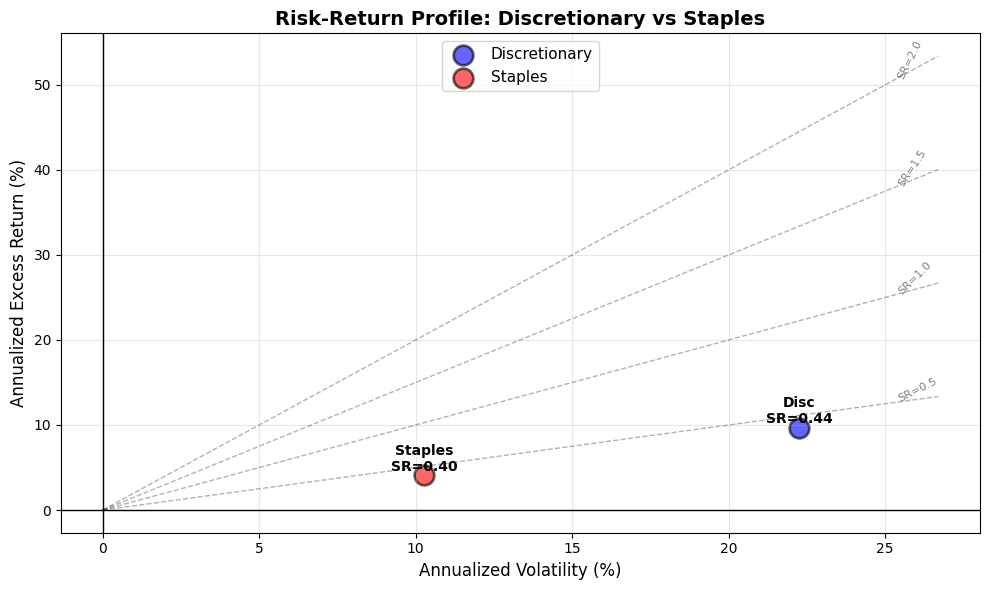


Discretionary: 9.69% return, 22.24% volatility
Staples:       4.12% return, 10.27% volatility


In [26]:
# Create risk-return scatter plot using annual excess returns
fig, ax = plt.subplots(figsize=(10, 6))

# Annual stats come from excess returns already adjusted for risk-free
disc_annual_return = annual_disc_clean.mean()
disc_annual_vol = annual_disc_clean.std(ddof=1)

stap_annual_return = annual_stap_clean.mean()
stap_annual_vol = annual_stap_clean.std(ddof=1)

# Plot
ax.scatter(disc_annual_vol, disc_annual_return, s=200, c='blue',
           alpha=0.6, edgecolors='black', linewidth=2, label='Discretionary')
ax.scatter(stap_annual_vol, stap_annual_return, s=200, c='red',
           alpha=0.6, edgecolors='black', linewidth=2, label='Staples')

# Add labels
ax.text(disc_annual_vol, disc_annual_return + 0.5,
        f'Disc\nSR={sharpe_disc:.2f}', ha='center', fontsize=10, fontweight='bold')
ax.text(stap_annual_vol, stap_annual_return + 0.5,
        f'Staples\nSR={sharpe_stap:.2f}', ha='center', fontsize=10, fontweight='bold')

# Add Sharpe ratio lines (from origin)
max_vol = max(disc_annual_vol, stap_annual_vol) * 1.2
for sr in [0.5, 1.0, 1.5, 2.0]:
    ax.plot([0, max_vol], [0, sr * max_vol], 'k--', alpha=0.3, linewidth=1)
    ax.text(max_vol * 0.95, sr * max_vol * 0.95, f'SR={sr}',
            fontsize=8, alpha=0.5, rotation=np.degrees(np.arctan(sr)))

ax.set_xlabel('Annualized Volatility (%)', fontsize=12)
ax.set_ylabel('Annualized Excess Return (%)', fontsize=12)
ax.set_title('Risk-Return Profile: Discretionary vs Staples', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

print(f"\nDiscretionary: {disc_annual_return:.2f}% return, {disc_annual_vol:.2f}% volatility")
print(f"Staples:       {stap_annual_return:.2f}% return, {stap_annual_vol:.2f}% volatility")
